In [1]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
import spm1d.stats.c
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font
import spm1d
from stressgait_analysis.dataset import StressGaitDataset

# Inset axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib widget
%load_ext autoreload
%autoreload 2

from matplotlib.patches import Rectangle, ConnectionPatch


import warnings
warnings.simplefilter(action='ignore')
import numpy as np

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

controls_color = sns.color_palette(cmaps.wiso)[1]
omc_color = sns.color_palette(cmaps.med_dark)[1]

stressgait = {
    "omc": omc_color,
    "control": controls_color
}

In [3]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
gait_data_path = Path(config_dict[deploy_type]["gait_data_path"])

export_path = Path("../../exports")
plot_path = export_path.joinpath("plots")
bp.utils.file_handling.mkdirs([export_path, plot_path])

export_path

PosixPath('../../exports')

In [4]:
dataset = StressGaitDataset(base_path, coarse_condition=True, gait_data_path=gait_data_path, specify_bouts=True, specify_speed=True)


# Gait variability

compute with coefficient of variation based on Winter, 2009

In [5]:
kinematics = dataset.kinematics.droplevel(level="bout")

In [6]:
bad_cycles = kinematics[kinematics['elbow_angle']<80].index.droplevel('percentage_of_stride').drop_duplicates()
# Step 2: Filter out those cycles
kinematics_clean_arms = kinematics[~kinematics.index.droplevel('percentage_of_stride').isin(bad_cycles)]

In [7]:
def compute_cv(trial):

    std_trial = trial.groupby(["percentage_of_stride"]).std()
    mean_trial = trial.groupby(["percentage_of_stride"]).mean()

    mean_std_squared = std_trial.pow(2).mean()
    return np.sqrt(mean_std_squared) / mean_trial.mean()


In [8]:
cv = kinematics.groupby(["participant", "condition", "speed"]).apply(compute_cv)
cv_per_person = cv.groupby(["participant", "condition"]).mean()

cv_arms = kinematics_clean_arms.groupby(["participant", "condition", "speed"]).apply(compute_cv)
cv_per_person_arms = cv_arms.groupby(["participant", "condition"]).mean()

cv_per_person.loc[:,["elbow_angle", "shoulder_angle", "arm_swing"]] = cv_per_person_arms.loc[:,["elbow_angle", "shoulder_angle", "arm_swing"]]

In [9]:
cv_per_group = cv_per_person.mean()
cv_per_group

hip_flexion       1.096483
knee_flexion      0.128726
elbow_angle       0.027554
shoulder_angle    0.018216
arm_swing         0.409783
dtype: float64

In [10]:
cv_per_group = cv_per_person.groupby(["condition"]).median()
cv_per_group

,hip_flexion,knee_flexion,elbow_angle,shoulder_angle,arm_swing
condition,,,,,
control,0.282785,0.109279,0.020395,0.017425,0.480886
omc,0.352119,0.115605,0.016699,0.015019,0.310705


In [11]:
cv_per_group = cv_per_person.groupby(["condition"]).mean()
cv_per_group

,hip_flexion,knee_flexion,elbow_angle,shoulder_angle,arm_swing
condition,,,,,
control,1.320660,0.123589,0.033187,0.019835,0.453347
omc,0.872306,0.133863,0.021922,0.016597,0.366218


In [12]:
df_long = cv_per_person.reset_index().melt(
    id_vars=["participant", "condition"],  # Keep these columns
    var_name="angle",  # Name for the melted variable column
    value_name="value"  # Name for the melted value column
)


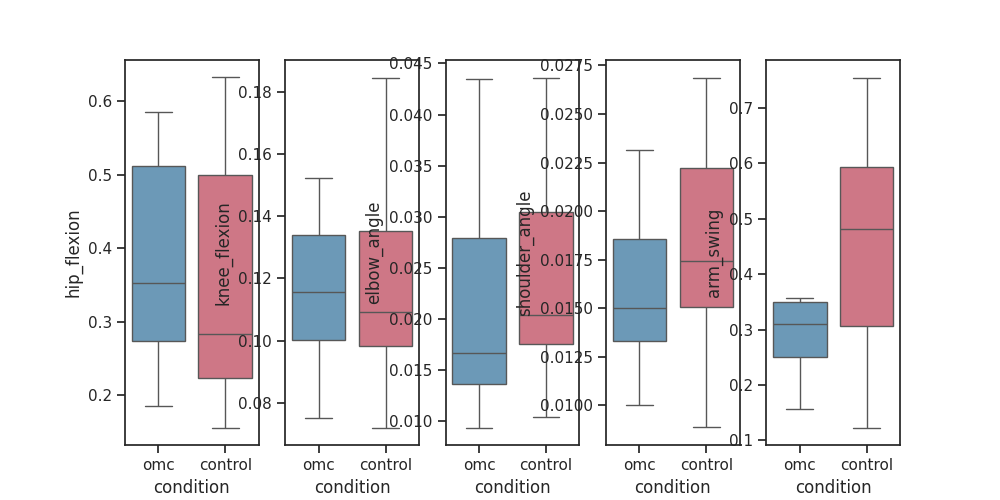

In [13]:
fig, axs=plt.subplots(ncols=5)

for c, ax in zip(cv_per_person.columns, axs):
    sns.boxplot(data = cv_per_person[c].reset_index(), x="condition", y=c, hue = "condition", ax=ax, showfliers=False, palette=stressgait)

<Axes: xlabel='angle', ylabel='value'>

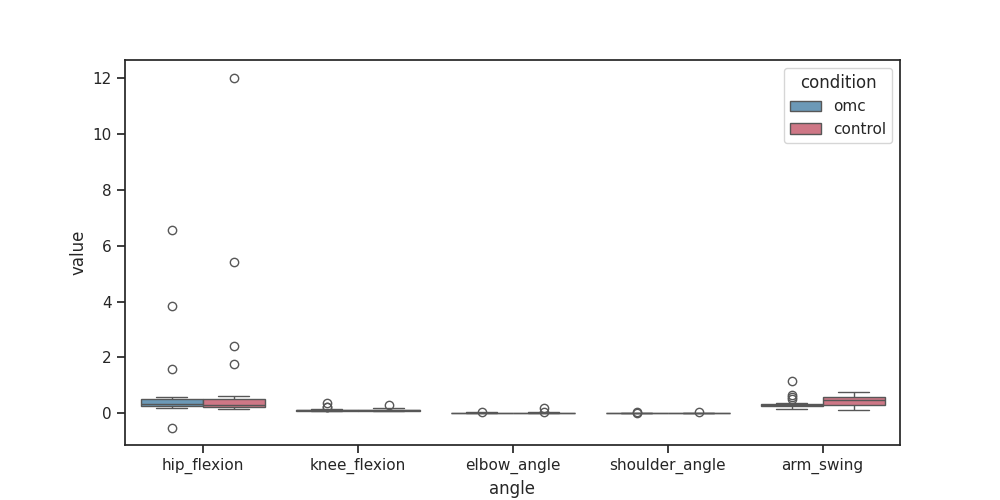

In [14]:
plt.figure()
sns.boxplot(x="angle", y="value", hue="condition", data=df_long,showfliers=True, palette=stressgait)

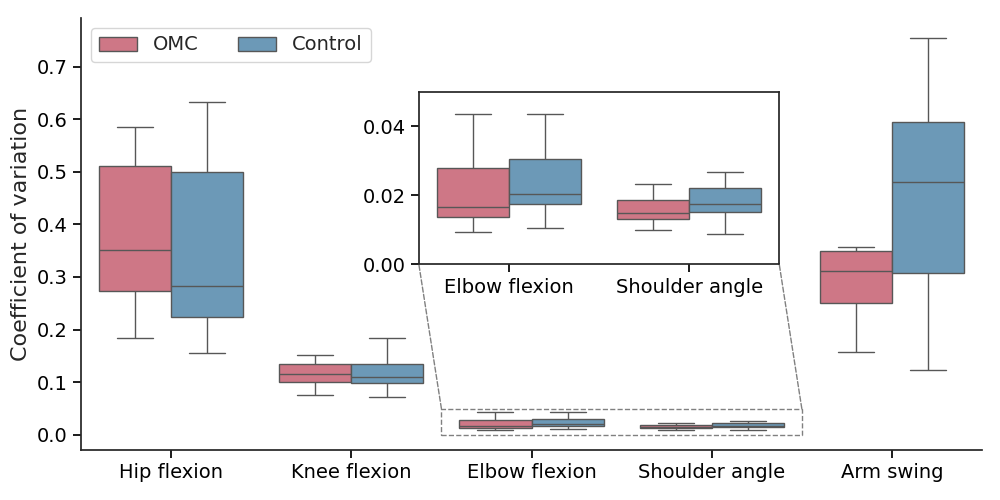

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_style("white")
#main plot
sns.boxplot(x="angle", y="value", hue="condition", data=df_long, showfliers=False, ax=ax,palette={controls_color, omc_color})
plt.ylabel("Coefficient of variation", fontsize=16)
ax.set_xticklabels(["Hip flexion", "Knee flexion", "Elbow flexion", "Shoulder angle", "Arm swing"], fontsize=14)
plt.xlabel("")


axins = inset_axes(ax,width="40%", height="40%",loc='upper center',bbox_to_anchor=(0.075, -0.1, 1, 1),bbox_transform=ax.transAxes, borderpad=2)
zoom_angles = ["elbow_angle", "shoulder_angle"]
df_zoom = df_long[df_long["angle"].isin(zoom_angles)]
sns.boxplot(x="angle", y="value", hue="condition", data=df_zoom, showfliers=False, palette={controls_color, omc_color})
axins.set_ylim(0, 0.05)
axins.get_legend().remove()
axins.set_xlabel("")
axins.set_ylabel("")
axins.tick_params(axis='x', labelsize=14)

# === Manually Draw Rectangle ===
# Get the positions of categories
x_ticks = list(df_long["angle"].unique())
x_start = x_ticks.index("elbow_angle") - 0.5
x_end = x_ticks.index("shoulder_angle") + 0.5
y_min, y_max = 0, 0.05

# Add rectangle to main plot
rect = Rectangle((x_start, y_min), x_end - x_start, y_max,
                 linewidth=1, edgecolor='gray', facecolor='none', linestyle='--')
ax.add_patch(rect)
axins.set_xticklabels(["Elbow flexion", "Shoulder angle"])
# === Manually Draw Connecting Lines ===
# Get inset and main plot coordinates
# (corner of rectangle → corner of inset)
coordsA = [(x_start, y_max), (x_end, y_max)]
coordsB = [(0, 0), (1, 0)]  # top-left and bottom-right in inset axes

for (xa, ya), (xb, yb) in zip(coordsA, coordsB):
    con = ConnectionPatch(xyA=(xa, ya), coordsA=ax.transData,xyB=(xb, yb), coordsB=axins.transAxes,color="gray", linestyle="--", linewidth=1)
    fig.add_artist(con)

plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles = handles, loc="upper left", ncol=2, fontsize=14, labels=['OMC', 'Control'])
ax.tick_params(axis='both', colors='black', labelsize=14, left=True,bottom=True, labelbottom=True)
axins.tick_params(axis='both', colors='black', labelsize=14, left=True,bottom=True, labelbottom=True)


plt.show()
plt.savefig("../../exports/variability.pdf")



In [16]:
from scipy.stats import shapiro

# Apply Shapiro-Wilk test to each angle column, grouped by condition
normality_results = df_long.groupby(['condition', "angle"], group_keys=False)["value"].apply(lambda g: pg.normality(g))
normality_results

W          pval  normal
control arm_swing       0.967490  7.012332e-01    True
        elbow_angle     0.491799  2.681955e-07   False
        hip_flexion     0.465074  1.559534e-07   False
        knee_flexion    0.774923  3.738391e-04   False
        shoulder_angle  0.734376  1.055771e-04   False
omc     arm_swing       0.722231  7.370773e-05   False
        elbow_angle     0.848936  5.116192e-03   False
        hip_flexion     0.535099  6.712802e-07   False
        knee_flexion    0.740102  1.254394e-04   False
        shoulder_angle  0.833044  2.807478e-03   False

In [17]:
test_results = df_long.groupby(["angle"], group_keys=False).apply(lambda g: pg.pairwise_tests(g, parametric=False, dv = "value", between="condition"))
test_results["p_corr"] = test_results["p-unc"]*len(df_long.angle.unique())
test_results["p_corr"].clip(upper=1, inplace=True)
test_results

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges,p_corr
0,condition,control,omc,False,False,266.0,two-sided,0.076431,0.408704,0.382155
0,condition,control,omc,False,False,253.0,two-sided,0.155570,0.378898,0.777850
0,condition,control,omc,False,False,168.0,two-sided,0.394171,0.192834,1.000000
0,condition,control,omc,False,False,189.0,two-sided,0.776391,-0.173288,1.000000
0,condition,control,omc,False,False,254.0,two-sided,0.147847,0.403198,0.739233
